# AWESim SOSS

**Advanced Webb Exposure Simulator for SOSS**

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import astropy.units as q
import astropy.constants as ac
from bokeh.io import output_notebook
from bokeh.plotting import figure, show
import batman
from pkg_resources import resource_filename
from awesimsoss import awesim
import matplotlib.pyplot as plt

output_notebook()

Loading BokehJS ...

## M Dwarf (no planet)

Text(0, 0.5, 'Flux Density [$\\rm erg/s/cm^2/A$]')

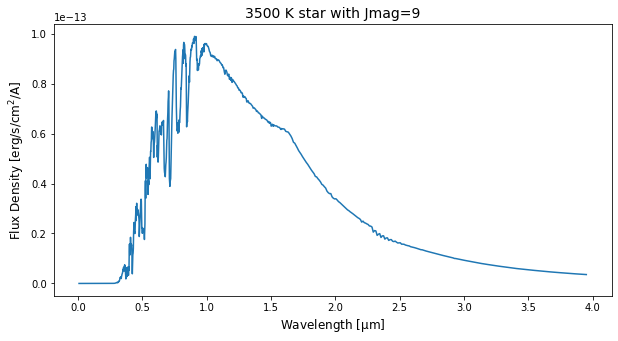

In [3]:
# Get the wavelength and flux of the star with units - standard spectrum which comes with awesimsoss 
star = np.genfromtxt(resource_filename('awesimsoss','files/scaled_spectrum.txt'), unpack=True)
star1D = [star[0]*q.um, (star[1]*q.W/q.m**2/q.um).to(q.erg/q.s/q.cm**2/q.AA)]  # assign um units to wavelength and convert flux units
star1D = [i[:1000] for i in star1D]  # Only use the first 1000 values


f, ax = plt.subplots(figsize=(10,5))
ax.plot(star1D[0], star1D[1])
ax.set_title('3500 K star with Jmag=9', fontsize=14)
ax.set_xlabel(r'Wavelength [$\rm \mu m$]', fontsize=12)
ax.set_ylabel(r'Flux Density [$\rm erg/s/cm^2/A$]', fontsize=12)

In [4]:
# Initialize the simulation with 3 groups and 10 integrations
my_TSO = awesim.TSO(ngrps=3, nints=10, star=star1D, target='WASP-107')  # keyword arguments explicitly specified for clarity
Time_sec = np.arange(30)*5.491 + 5.491 # create time axis based off of number of groups/integrations and frame time (5.419s)

Coordinates 188.38684999999998 -10.146173055555556 for 'WASP-107' found in Simbad!


In [5]:
# Run the simulation - takes ~1 minutes
my_TSO.simulate()

Calculating order 1 light curves...
Lightcurves finished: 28.07 s
Constructing order 1 traces...
Order 1 traces finished: 1.842 s
Calculating order 2 light curves...
Lightcurves finished: 23.245 s
Constructing order 2 traces...
Order 2 traces finished: 1.53 s
Adding noise to TSO...
Noise model finished: 3.834 s

Total time: 59.735 s


In [ ]:
# plot the TSO object - note that the jupyter notebook stops saving when this is called 
my_TSO.plot()  

In [7]:
# plot the ramp for each integration
my_TSO.plot_ramp(order=1)

In [8]:
# plot the spectrum in a given frame (simple sum along y-axis of trace)
my_TSO.plot_spectrum(frame=13, scale='linear')

## M Dwarf (with planet)

(0, 4)

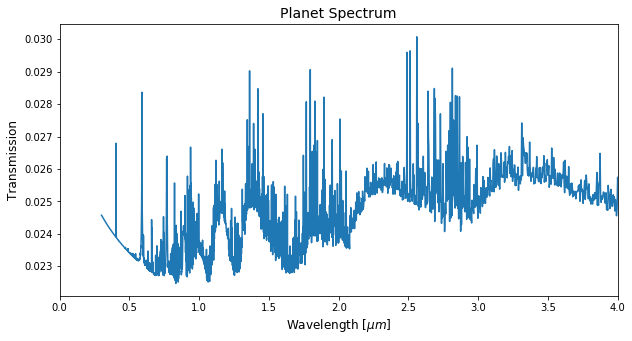

In [9]:
# Get the planet data - comes with the awesimsoss installation
planet_file = resource_filename('awesimsoss', '/files/WASP107b_pandexo_input_spectrum.dat')
planet = np.genfromtxt(planet_file, unpack=True)
planet1D = [planet[0]*q.um, planet[1]]

f, ax = plt.subplots(figsize=(10,5))
ax.plot(*planet1D)
ax.set_title('Planet Spectrum', fontsize=14)
ax.set_xlabel(r'Wavelength [$\mu m$]', fontsize=12)
ax.set_ylabel('Transmission', fontsize=12)
ax.set_xlim(0,4)

In [17]:
# Set the orbital parameters - they have been made up to fit with number of groups/integrations
params = batman.TransitParams()
params.t0 = 0.001              # Time of inferior conjunction (days)
params.per = 0.03              # Orbital period
params.rp = 0.15                # Planet radius (in units of R*)
params.a = 0.0558*q.AU.to(ac.R_sun)*0.66                  # Semi-major axis (in units of R*)
params.inc = 89.8               # Orbital inclination (in degrees)
params.ecc = 0.                 # Eccentricity
params.w = 90.                  # Longitude of periastron (in degrees) 
params.u = [0.1, 0.1]           # Limb darkening coefficients [u1, u2]
params.limb_dark = "quadratic"  # Limb darkening model

# Make the transit model and add the stellar params
day2sec = 86400
tmodel = batman.TransitModel(params, Time_sec/day2sec)  # Make sure to work in days!
tmodel.teff = 3500              # Effective temperature of the host star
tmodel.logg = 5                 # log surface gravity of the host star
tmodel.feh = 0                  # Metallicity of the host star

Text(0, 0.5, 'Relative Flux')

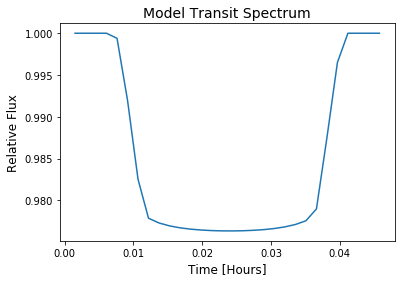

In [18]:
flux = tmodel.light_curve(params)

plt.plot(Time_sec/day2sec*24, flux)
plt.title('Model Transit Spectrum', fontsize=14)
plt.xlabel('Time [Hours]', fontsize=12)
plt.ylabel('Relative Flux', fontsize=12)

In [19]:
# Run the simulation, this time including the planet - takes ~1 minute
# planet is the planet spectrum, and tmodel passes the transit parameters
my_TSO.simulate(planet=planet1D, tmodel=tmodel)

Please set a stellar intensity model grid with the 'model_grid' attribute to update the limb darkening coefficients
Calculating order 1 light curves...
Lightcurves finished: 22.878 s
Constructing order 1 traces...
Order 1 traces finished: 1.624 s
Calculating order 2 light curves...
Lightcurves finished: 21.97 s
Constructing order 2 traces...
Order 2 traces finished: 1.509 s
Adding noise to TSO...
Noise model finished: 3.387 s

Total time: 52.493 s


In [20]:
my_TSO.time = my_TSO.time*q.s.to('d')  # the time unit of the TSO axis needs to be in days to use plot_lightcurve

In [21]:
# Plot the lightcurve - each point is an integration
my_TSO.plot_lightcurve(column=[1710], time_unit='d')

## Exporting Results

In [6]:
my_TSO.export('my_soss_simulation.fits')

File saved as ng2ni1.fits
